In [5]:
import numpy as np
import matplotlib.pyplot as plt
from starfinder.tycho2 import Tycho2Reader
import pandas as pd

# Cell 1: Load the star catalog
def load_star_catalog(data_dir):
    reader = Tycho2Reader(data_dir)
    catalog = reader.read_catalog()
    # Select relevant columns and convert to numpy array
    stars = catalog[["RAdeg", "DEdeg", "VT"]].values
    assert type(stars) == np.ndarray
    # Convert RA from degrees to hours
    stars[:, 0] /= 15
    print(f"Loaded {len(stars)} stars from Tycho-2 catalog")
    return stars

data_dir = "data/tycho2"
stars = load_star_catalog(data_dir)


Loaded 2539913 stars from Tycho-2 catalog


In [6]:

# Display the first few rows and some statistics
print(stars[:5])
print("\nStatistics:")
print(pd.DataFrame(stars, columns=["RA", "Dec", "VT"]).describe())

# Cell 2: Define helper functions
def ra_dec_to_eci(ra, dec):
    ra_rad = ra * np.pi / 12  # Convert RA to radians
    dec_rad = dec * np.pi / 180  # Convert Dec to radians
    x = np.cos(ra_rad) * np.cos(dec_rad)
    y = np.sin(ra_rad) * np.cos(dec_rad)
    z = np.sin(dec_rad)
    return np.array([x, y, z])

def quaternion_to_rotation_matrix(q):
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*q2**2 - 2*q3**2, 2*q1*q2 - 2*q0*q3, 2*q1*q3 + 2*q0*q2],
        [2*q1*q2 + 2*q0*q3, 1 - 2*q1**2 - 2*q3**2, 2*q2*q3 - 2*q0*q1],
        [2*q1*q3 - 2*q0*q2, 2*q2*q3 + 2*q0*q1, 1 - 2*q1**2 - 2*q2**2]
    ])

def eci_to_body_frame(eci_coords, attitude_quaternion):
    R = quaternion_to_rotation_matrix(attitude_quaternion)
    return R.T @ eci_coords

def project_to_image_plane(body_coords, fov, resolution):
    f = 1 / np.tan(np.radians(fov) / 2)
    x, y, z = body_coords
    if z > 0:
        u = f * x / z
        v = f * y / z
        width, height = resolution
        pixel_x = int((u + 1) * width / 2)
        pixel_y = int((1 - v) * height / 2)
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            return pixel_x, pixel_y
    return None

def calculate_star_visibility(magnitude, iso, shutter_speed):
    brightness = 10 ** (-(magnitude - 6) / 2.5)  # Shift magnitude by 6 to make stars brighter
    exposure = iso * shutter_speed / 100
    return brightness * exposure


[[1.02666667e-01 8.80000000e+01 9.99000000e+02]
 [1.01333333e-01 9.30000000e+00 9.99000000e+02]
 [1.02666667e-01 1.08500000e+02 9.99000000e+02]
 [1.03333333e-01 3.00000000e+01 1.80000000e+01]
 [1.04666667e-01 2.14000000e+01 1.80000000e+01]]

Statistics:
                 RA           Dec            VT
count  2.539913e+06  2.539913e+06  2.539913e+06
mean   1.098605e-01  6.356634e+01  9.212302e+02
std    1.006653e-02  3.661170e+01  1.933894e+02
min    4.800000e-02  3.100000e+00  3.000000e+00
25%    1.053333e-01  3.510000e+01  9.990000e+02
50%    1.113333e-01  6.130000e+01  9.990000e+02
75%    1.160000e-01  8.700000e+01  9.990000e+02
max    1.573333e-01  2.000000e+02  9.990000e+02


In [7]:

# Test individual functions
# Test ra_dec_to_eci
test_ra, test_dec = stars[0, :2]
eci_coords = ra_dec_to_eci(test_ra, test_dec)
print(f"ECI coordinates for first star: {eci_coords}")

# Test eci_to_body_frame
attitude = np.array([1, 0, 0, 0])  # Identity quaternion
body_coords = eci_to_body_frame(eci_coords, attitude)
print(f"Body coordinates for first star: {body_coords}")

# Test project_to_image_plane
fov = 50
resolution = (800, 600)
projection = project_to_image_plane(body_coords, fov, resolution)
print(f"Image projection for first star: {projection}")

# Test calculate_star_visibility
magnitude = stars[0, 2]
iso = 1600
shutter_speed = 1
visibility = calculate_star_visibility(magnitude, iso, shutter_speed)
print(f"Visibility for first star: {visibility}")


ECI coordinates for first star: [3.48868912e-02 9.37918192e-04 9.99390827e-01]
Body coordinates for first star: [3.48868912e-02 9.37918192e-04 9.99390827e-01]
Image projection for first star: (429, 299)
Visibility for first star: 0.0


Number of bright stars: 2527
RA range: -1358.70 to 873.90
Dec range: -619.80 to 585.10
Star: RA=191.00, Dec=-3.90, Mag=8.00, Pixel=(510,18)
Star: RA=191.00, Dec=-3.90, Mag=8.00, Pixel=(510,18)
Star: RA=183.20, Dec=-4.70, Mag=9.00, Pixel=(492,175)
Total stars: 2527
Stars in front of camera: 115
Visible stars: 3


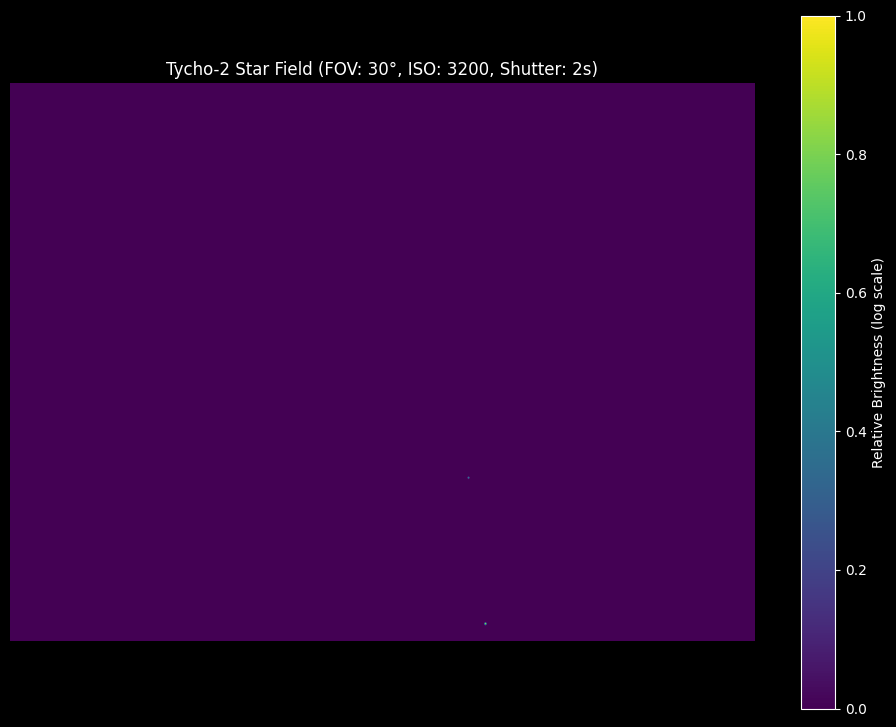

Image shape: (600, 800)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 9.055189959814236e-06


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

def ra_dec_to_eci(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    x = np.cos(ra_rad) * np.cos(dec_rad)
    y = np.sin(ra_rad) * np.cos(dec_rad)
    z = np.sin(dec_rad)
    return np.array([x, y, z])

def eci_to_body_frame(eci_coords, attitude_matrix):
    return attitude_matrix @ eci_coords

def project_to_image_plane(body_coords, fov, resolution):
    f = 1 / np.tan(np.radians(fov) / 2)
    x, y, z = body_coords
    if z > 0:
        u = f * x / z
        v = f * y / z
        width, height = resolution
        pixel_x = int((u + 1) * width / 2)
        pixel_y = int((v + 1) * height / 2)
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            return pixel_x, pixel_y
    return None

def calculate_star_visibility(magnitude, iso, shutter_speed):
    brightness = 10 ** (-(magnitude - 6) / 2.5)
    exposure = iso * shutter_speed / 100
    return brightness * exposure

def add_star_to_image(image, x, y, visibility):
    height, width = image.shape
    y_min, y_max = max(0, y-2), min(height, y+3)
    x_min, x_max = max(0, x-2), min(width, x+3)
    
    y_range = np.arange(y_min, y_max)
    x_range = np.arange(x_min, x_max)
    
    y_grid, x_grid = np.meshgrid(y_range - y, x_range - x, indexing='ij')
    
    r_squared = x_grid**2 + y_grid**2
    gaussian = np.exp(-r_squared / (2 * 0.5**2))
    
    image[y_min:y_max, x_min:x_max] += visibility * gaussian

def generate_star_image(stars_df, attitude_matrix, fov, resolution, iso, shutter_speed):
    width, height = resolution
    image = np.zeros((height, width))
    visible_stars = 0
    total_stars = len(stars_df)
    stars_in_fov = 0

    for _, star in stars_df.iterrows():
        ra, dec, magnitude = star['mRAdeg'], star['mDEdeg'], star['VT']
        if np.isnan(ra) or np.isnan(dec) or np.isnan(magnitude):
            continue  # Skip stars with missing data
        
        eci_coords = ra_dec_to_eci(ra, dec)
        body_coords = eci_to_body_frame(eci_coords, attitude_matrix)
        
        # Check if star is in front of the camera
        if body_coords[2] > 0:
            stars_in_fov += 1
        
        projection = project_to_image_plane(body_coords, fov, resolution)

        if projection:
            x, y = projection
            visibility = calculate_star_visibility(magnitude, iso, shutter_speed)
            add_star_to_image(image, x, y, visibility)
            visible_stars += 1
            if visible_stars <= 10:  # Print details for first 10 visible stars
                print(f"Star: RA={ra:.2f}, Dec={dec:.2f}, Mag={magnitude:.2f}, Pixel=({x},{y})")

    print(f"Total stars: {total_stars}")
    print(f"Stars in front of camera: {stars_in_fov}")
    print(f"Visible stars: {visible_stars}")
    return image

# Load Tycho-2 data
reader = Tycho2Reader('data/tycho2')  # Replace with your actual data directory
stars_df = reader.read_catalog()

# Convert columns to numeric type and filter brighter stars
stars_df['mRAdeg'] = pd.to_numeric(stars_df['mRAdeg'], errors='coerce')
stars_df['mDEdeg'] = pd.to_numeric(stars_df['mDEdeg'], errors='coerce')
stars_df['VT'] = pd.to_numeric(stars_df['VT'], errors='coerce')

# Convert RA from hours to degrees if necessary
if stars_df['mRAdeg'].max() <= 24:
    stars_df['mRAdeg'] *= 15

# Increase magnitude limit to include more stars
bright_stars = stars_df[stars_df['VT'] <= 9].dropna(subset=['mRAdeg', 'mDEdeg', 'VT'])

print(f"Number of bright stars: {len(bright_stars)}")
print(f"RA range: {bright_stars['mRAdeg'].min():.2f} to {bright_stars['mRAdeg'].max():.2f}")
print(f"Dec range: {bright_stars['mDEdeg'].min():.2f} to {bright_stars['mDEdeg'].max():.2f}")

# Set parameters
fov = 30  # Field of view in degrees
resolution = (800, 600)
iso = 3200
shutter_speed = 2

# Set camera attitude (pointing towards the mean RA and Dec of the stars)
ra_center = bright_stars['mRAdeg'].mean()
dec_center = bright_stars['mDEdeg'].mean()
rot = Rotation.from_euler('zyx', [-ra_center, 90-dec_center, 0], degrees=True)
attitude_matrix = rot.as_matrix()

# Generate image
image = generate_star_image(bright_stars, attitude_matrix, fov, resolution, iso, shutter_speed)

# Apply logarithmic scaling and normalization
image = np.log1p(image)
image /= np.max(image) if np.max(image) > 0 else 1

# Display the image
plt.figure(figsize=(12, 9))
plt.imshow(image, cmap="viridis", origin='lower')
plt.title(f"Tycho-2 Star Field (FOV: {fov}°, ISO: {iso}, Shutter: {shutter_speed}s)")
plt.axis("off")
plt.colorbar(label="Relative Brightness (log scale)")
plt.show()

# Print some statistics about the image
print(f"Image shape: {image.shape}")
print(f"Min pixel value: {image.min()}")
print(f"Max pixel value: {image.max()}")
print(f"Mean pixel value: {image.mean()}")
